# Exploratory Data Analysis (EDA)

EDA of ADNI `D1_D2` dataset of the [TADPOLE Challenge](https://tadpole.grand-challenge.org/Home/)

### Author
Ajinkya Indulkar

In [4]:
# import libraries
import warnings

warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from pyts.preprocessing import InterpolationImputer

%matplotlib inline

### Load Data

In [5]:
ROOT = "./tadpole_challenge/"

In [6]:
# load csv
d1_d2_df = pd.read_csv(ROOT+"TADPOLE_D1_D2.csv")

As suggested by the challenge, we select a list of biomarkers as a starting point.

In [7]:
# list of columns for training (starting point)
getting_started = ["RID", "VISCODE", "DX_bl", "DX", "ADAS13", "Ventricles", "CDRSB", "ADAS11", "MMSE", 
                   "RAVLT_immediate", "Hippocampus", "WholeBrain", "Entorhinal", "MidTemp", "FDG", "AV45",
                   "ABETA_UPENNBIOMK9_04_19_17", "TAU_UPENNBIOMK9_04_19_17", "PTAU_UPENNBIOMK9_04_19_17", "APOE4", 
                   "AGE"]

In [8]:
# filter dataframe based on list of columns selected
gs_df = d1_d2_df[getting_started]

### Data Cleaning

In [9]:
# filter out only baseline visits
train_df = gs_df[gs_df["VISCODE"] == "bl"].reset_index(drop=True).drop(columns='VISCODE')

In [10]:
# observing unique values of columns with dtype=object
cols = ['DX_bl', 'DX', 'ABETA_UPENNBIOMK9_04_19_17', 
        'TAU_UPENNBIOMK9_04_19_17', 'PTAU_UPENNBIOMK9_04_19_17']
for c in cols:
    print(c, ":", train_df[c].unique())

DX_bl : ['CN' 'AD' 'LMCI' 'EMCI' 'SMC']
DX : ['NL' 'Dementia' 'MCI' 'Dementia to MCI' 'MCI to Dementia' 'MCI to NL' nan
 'NL to MCI']
ABETA_UPENNBIOMK9_04_19_17 : [' ' '741.5' '1501' ... '558.9' '416.8' '1460']
TAU_UPENNBIOMK9_04_19_17 : [' ' '239.7' '153.1' ... '268.4' '88.69' '224.9']
PTAU_UPENNBIOMK9_04_19_17 : [' ' '22.83' '13.29' ... '26.11' '8.53' '20.9']


#### Fix Columns with erroneous data

Replace missing data points/features with `None` datatype to be handled later by Imputation by Interpolation.

In [11]:
# fix "DX" column
train_df['DX'] = train_df['DX'].fillna('nan')
# remove rows with nan DX values
train_df = train_df[train_df['DX'] != 'nan'].reset_index(drop=True)

In [12]:
# fix "ABETA_UPENNBIOMK9_04_19_17, TAU_UPENNBIOMK9_04_19_17, PTAU_UPENNBIOMK9_04_19_17" column
err_cols = ["ABETA_UPENNBIOMK9_04_19_17", "TAU_UPENNBIOMK9_04_19_17", "PTAU_UPENNBIOMK9_04_19_17"]

for c in err_cols:
    train_df[c] = train_df[c].apply(lambda x: None if x == ' ' or '<' in x or '>' in x else x)
    train_df[c] = train_df[c].astype(float)

In [13]:
# convert "DX_bl" and "DX" to categorical values
train_df[['DX_bl', 'DX']] = train_df[['DX_bl', 'DX']].apply(LabelEncoder().fit_transform)

#### imputation by interpolation

In [14]:
impcols = [c for c in train_df.columns.tolist() if c not in ['RID', 'DX_bl']]

In [15]:
features = train_df.drop(columns=['RID', 'DX_bl']).to_numpy()
features = InterpolationImputer().fit_transform(features)

In [16]:
train_df[impcols] = pd.DataFrame(features)

In [17]:
# check data
train_df.head()

,RID,DX_bl,DX,ADAS13,Ventricles,CDRSB,ADAS11,MMSE,RAVLT_immediate,Hippocampus,WholeBrain,Entorhinal,MidTemp,FDG,AV45,ABETA_UPENNBIOMK9_04_19_17,TAU_UPENNBIOMK9_04_19_17,PTAU_UPENNBIOMK9_04_19_17,APOE4,AGE
0,2,1,5.0,18.67,118233.0,0.0,10.67,28.0,44.0,8336.0,1229740.0,4177.0,27936.0,1.36926,1.095408,0.821556,0.547704,0.273852,0.0,74.3
1,3,0,0.0,31.00,84599.0,4.5,22.00,20.0,22.0,5319.0,1129830.0,1791.0,18422.0,1.09079,371.295395,741.500000,239.700000,22.830000,1.0,81.3
2,4,3,2.0,21.33,39605.0,1.0,14.33,27.0,37.0,6869.0,1154980.0,3983.0,19615.0,13577.00000,7539.000000,1501.000000,153.100000,13.290000,0.0,67.5
3,5,1,5.0,14.67,34062.0,0.0,8.67,29.0,37.0,7075.0,1116630.0,4433.0,21614.0,1.29799,274.298995,547.300000,337.000000,33.430000,0.0,73.7
4,6,3,2.0,25.67,39826.0,0.5,18.67,25.0,30.0,5348.0,927510.0,2277.0,17802.0,14835.00000,11868.000000,8901.000000,5934.000000,2967.000000,0.0,80.4


In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1730 entries, 0 to 1729
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   RID                         1730 non-null   int64  
 1   DX_bl                       1730 non-null   int32  
 2   DX                          1730 non-null   float64
 3   ADAS13                      1730 non-null   float64
 4   Ventricles                  1730 non-null   float64
 5   CDRSB                       1730 non-null   float64
 6   ADAS11                      1730 non-null   float64
 7   MMSE                        1730 non-null   float64
 8   RAVLT_immediate             1730 non-null   float64
 9   Hippocampus                 1730 non-null   float64
 10  WholeBrain                  1730 non-null   float64
 11  Entorhinal                  1730 non-null   float64
 12  MidTemp                     1730 non-null   float64
 13  FDG                         1730 

### EDA

In [19]:
sns.set(style='whitegrid', palette="deep", font_scale=0.7, rc={"figure.figsize": [8, 5]})

#### Categorical Values Distribution

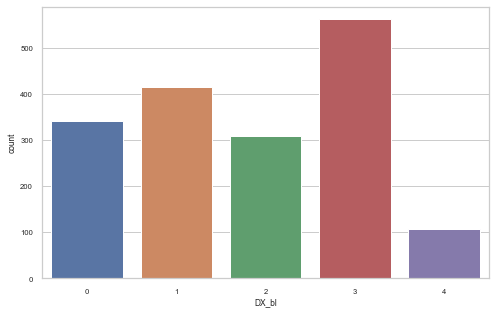

In [20]:
sns.countplot(x='DX_bl', data=train_df);

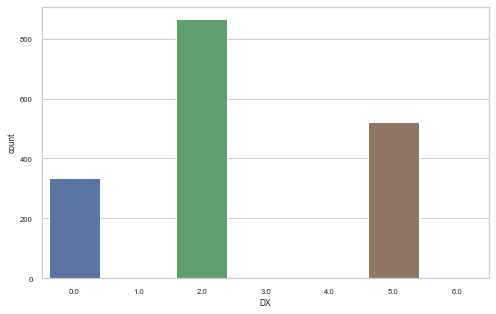

In [21]:
sns.countplot(x='DX', data=train_df);

#### Numerical Values Histogram

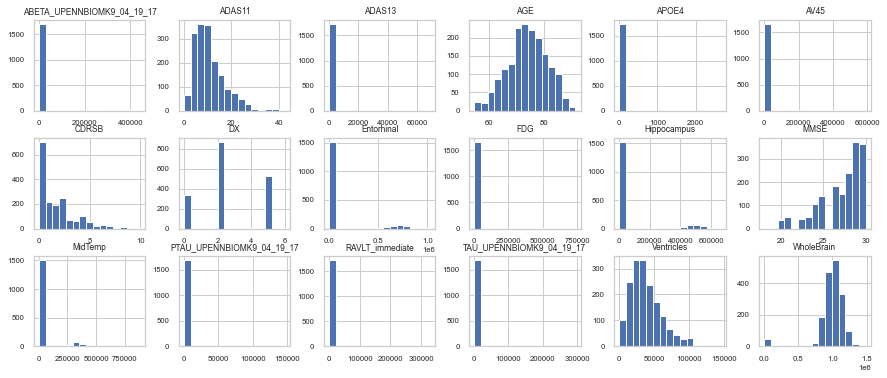

In [22]:
train_df[impcols].hist(bins=15, figsize=(15, 6), layout=(3, 6));

#### Feature Correlation Map

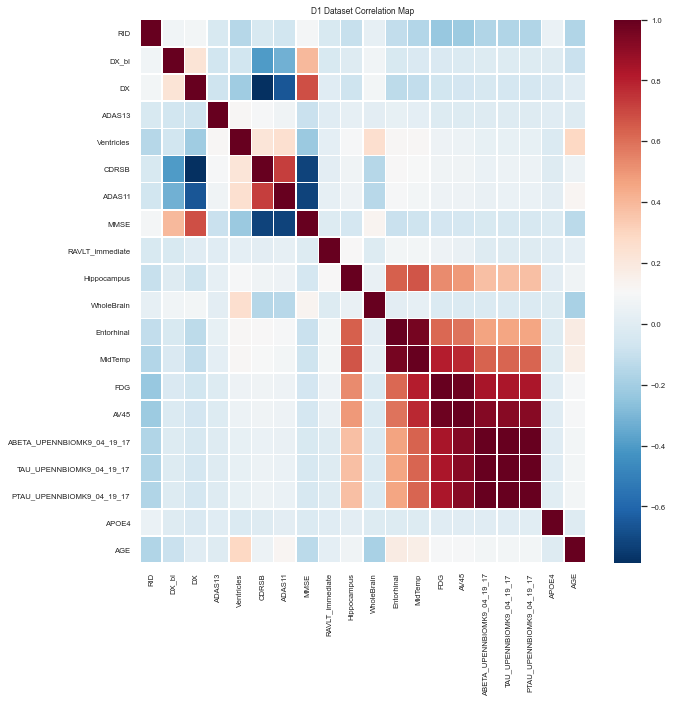

In [23]:
plt.figure(figsize=(10,10))
sns.heatmap(train_df.corr(), cmap='RdBu_r', linewidths=0.5)
plt.title("D1 Dataset Correlation Map")
plt.show()

In [43]:
train_df.drop(columns=['DX_bl', 'RID', 'DX', 'ADAS13', 'Ventricles']).corr()

,CDRSB,ADAS11,MMSE,RAVLT_immediate,Hippocampus,WholeBrain,Entorhinal,MidTemp,FDG,AV45,ABETA_UPENNBIOMK9_04_19_17,TAU_UPENNBIOMK9_04_19_17,PTAU_UPENNBIOMK9_04_19_17,APOE4,AGE
CDRSB,1.000000,0.723717,-0.722398,0.009981,0.068454,-0.147117,0.112218,0.102615,0.071010,0.066464,0.048020,0.053804,0.053158,-0.005637,0.057748
ADAS11,0.723717,1.000000,-0.718388,0.028567,0.062447,-0.137564,0.093861,0.085505,0.064589,0.059946,0.041428,0.046792,0.046270,0.011248,0.121042
MMSE,-0.722398,-0.718388,1.000000,-0.012326,-0.051281,0.130259,-0.090477,-0.080460,-0.057076,-0.053205,-0.036878,-0.043021,-0.042587,-0.018766,-0.134978
RAVLT_immediate,0.009981,0.028567,-0.012326,1.000000,0.110747,-0.013542,0.081403,0.082074,0.062127,0.040684,-0.006020,-0.005870,-0.005835,-0.001508,0.023077
Hippocampus,0.068454,0.062447,-0.051281,0.110747,1.000000,0.042279,0.643372,0.665681,0.526582,0.494424,0.377822,0.373141,0.373012,0.015500,0.067963
WholeBrain,-0.147117,-0.137564,0.130259,-0.013542,0.042279,1.000000,0.012894,0.023657,-0.022655,-0.023441,-0.021099,-0.023389,-0.023308,-0.012558,-0.182134
Entorhinal,0.112218,0.093861,-0.090477,0.081403,0.643372,0.012894,1.000000,0.962925,0.620842,0.589541,0.464390,0.459170,0.458845,-0.016478,0.179733
MidTemp,0.102615,0.085505,-0.080460,0.082074,0.665681,0.023657,0.962925,1.000000,0.807902,0.778250,0.636171,0.629571,0.629231,-0.016042,0.163264
FDG,0.071010,0.064589,-0.057076,0.062127,0.526582,-0.022655,0.620842,0.807902,1.000000,0.981880,0.840480,0.832990,0.832756,-0.004687,0.099403
AV45,0.066464,0.059946,-0.053205,0.040684,0.494424,-0.023441,0.589541,0.778250,0.981880,1.000000,0.927889,0.921513,0.921349,-0.003362,0.098447


,Brand,Price
0,NaN,22000
1,Toyota Corolla,25000
2,Ford Focus,27000
3,Audi A4,35000
